In [1]:
import numpy
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from tqdm import tqdm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Image

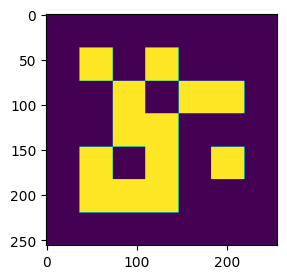

[[1.43732902e+03 0.00000000e+00 9.18169372e+02]
 [0.00000000e+00 1.43392453e+03 4.98012271e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.04581915 -0.19300152 -0.00258579 -0.00148166  0.15929305]]


In [2]:
def npy_to_gif(npy, filename):
    clip = mpy.ImageSequenceClip(list(npy), fps=30)
    clip.write_gif(filename)

# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_REFINE=aruco.RefineParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_5X5_1000)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)

ARUCO_MARKER = aruco.generateImageMarker(ARUCO_DICT, 0, 256)
plt.figure(figsize=(3,3)); plt.imshow(ARUCO_MARKER); plt.show()

marker_length = 0.07 # [m] 
mtx = numpy.load("mtx.npy")
dist = numpy.load("dist.npy")
print(mtx); print(dist)


In [3]:
def my_estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    '''
    This will estimate the rvec and tvec for each of the marker corners detected by:
       corners, ids, rejectedImgPoints = detector.detectMarkers(image)
    corners - is an array of detected corners for each detected marker in the image
    marker_size - is the size of the detected markers
    mtx - is the camera matrix
    distortion - is the camera distortion matrix
    RETURN list of rvecs, tvecs, and trash (so that it corresponds to the old estimatePoseSingleMarkers())
    '''
    marker_points = numpy.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=numpy.float32)
    trash = []
    rvecs = []
    tvecs = []
    
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash




# Create vectors we'll be using for rotations and translations for postures
#rvecs, tvecs = None, None

#cam = cv2.VideoCapture('Input_Video.mp4')
cam = cv2.VideoCapture(0)

XYZ = []
RPY = []
V_x = []
V_y = []
V_z = []

while(cam.isOpened()):
    # Capturing each frame of our video stream
    ret, QueryImg = cam.read()
    if ret == True:
        # grayscale image
        gray = cv2.cvtColor(QueryImg, cv2.COLOR_BGR2GRAY)
    
        # Detect Aruco markers
        corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
        rvecs, tvecs, _ = my_estimatePoseSingleMarkers(corners, marker_length, mtx, dist)      
        
        # Make sure all 5 markers were detected before printing them out
        #if ids is not None and len(ids) == 5:
        if ids is not None:
            # Print corners and ids to the console       
            for i, corner in zip(ids, corners):
                print('ID: {}; Corners: {}'.format(i, corner))

            # Outline all of the markers detected in our image
            QueryImg = aruco.drawDetectedMarkers(QueryImg, corners, borderColor=(0, 0, 255))
            for idx in range(len(ids)):
                QueryImg=cv2.drawFrameAxes(QueryImg,mtx,dist,rvecs[idx],tvecs[idx], marker_length/2)
            
                # R = cv2.Rodrigues(rvecs[idx])[0]
                # R_T = R.T
                # T = tvecs[idx]        
                # xyz = numpy.dot(R_T, - T).squeeze()
                # XYZ.append(xyz)
                # rpy = numpy.deg2rad(cv2.RQDecomp3x3(R_T)[0])
                # RPY.append(rpy)
                # V_x.append(numpy.dot(R_T, numpy.array([1,0,0])))
                # V_y.append(numpy.dot(R_T, numpy.array([0,1,0])))
                # V_z.append(numpy.dot(R_T, numpy.array([0,0,1])))
            R = cv2.Rodrigues(rvecs[0])[0] #it was rvecs in the original code
            R_T = R.T
            T = tvecs[0] #there was a transpose in the original code        
            xyz = numpy.dot(R_T, - T).squeeze()
            XYZ.append(xyz)
            rpy = numpy.deg2rad(cv2.RQDecomp3x3(R_T)[0])
            RPY.append(rpy)
            V_x.append(numpy.dot(R_T, numpy.array([1,0,0])))
            V_y.append(numpy.dot(R_T, numpy.array([0,1,0])))
            V_z.append(numpy.dot(R_T, numpy.array([0,0,1])))
        # Display our image
        cv2.imshow('QueryImage', QueryImg)


    # Exit at the end of the video on the 'q' keypress
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cam.release() 
cv2.destroyAllWindows()

ID: [673]; Corners: [[[ 53. 271.]
  [ 48. 255.]
  [ 50. 253.]
  [ 59. 260.]]]
ID: [110]; Corners: [[[327. 434.]
  [324. 438.]
  [317. 432.]
  [321. 428.]]]
ID: [381]; Corners: [[[ 92. 441.]
  [ 88. 449.]
  [ 86. 443.]
  [ 91. 431.]]]
ID: [2]; Corners: [[[ 60. 341.]
  [177. 358.]
  [153. 476.]
  [ 25. 462.]]]
ID: [2]; Corners: [[[ 61. 335.]
  [177. 354.]
  [149. 473.]
  [ 22. 456.]]]
ID: [2]; Corners: [[[ 59. 329.]
  [173. 349.]
  [143. 470.]
  [ 18. 452.]]]
ID: [2]; Corners: [[[172. 292.]
  [273. 329.]
  [242. 442.]
  [125. 403.]]]
ID: [2]; Corners: [[[181. 290.]
  [281. 330.]
  [247. 441.]
  [133. 400.]]]
ID: [2]; Corners: [[[187. 289.]
  [288. 331.]
  [253. 440.]
  [139. 398.]]]
ID: [2]; Corners: [[[192. 288.]
  [292. 330.]
  [257. 439.]
  [144. 396.]]]
ID: [2]; Corners: [[[196. 287.]
  [295. 330.]
  [259. 438.]
  [147. 394.]]]
ID: [2]; Corners: [[[198. 286.]
  [296. 329.]
  [261. 436.]
  [149. 392.]]]
ID: [2]; Corners: [[[199. 285.]
  [297. 328.]
  [262. 434.]
  [150. 391.]]]
ID: [2

In [4]:
def plot_all_frames(elev=90, azim=270):
    frames = []

    for t in tqdm(range(len(XYZ))):
        fig = plt.figure(figsize=(4,3))
        ax = Axes3D(fig)
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlim(-2, 2); ax.set_ylim(-2, 2); ax.set_zlim(-2, 2)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

        x, y, z = XYZ[t]
        ux, vx, wx = V_x[t]
        uy, vy, wy = V_y[t]
        uz, vz, wz = V_z[t]

        # draw marker
        ax.scatter(0, 0, 0, color="k")
        ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
        ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
        ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
        ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

        # draw camera
        if t < 5:
            ax.quiver(x, y, z, ux, vx, wx, length=0.5, color="k")
            ax.quiver(x, y, z, uy, vy, wy, length=0.5, color="k")
            ax.quiver(x, y, z, uz, vz, wz, length=0.5, color="k")
        else:
            ax.quiver(x, y, z, ux, vx, wx, length=0.5, color="r")
            ax.quiver(x, y, z, uy, vy, wy, length=0.5, color="g")
            ax.quiver(x, y, z, uz, vz, wz, length=0.5, color="b")

        # save for animation
        fig.canvas.draw()
        frames.append(numpy.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()

    return frames

In [5]:
frames = plot_all_frames(elev=105, azim=270)
npy_to_gif(frames, "sample1.gif"); Image(url='sample1.gif')

100%|████████████████████████████████████████████████████████████████████████████████| 869/869 [01:58<00:00,  7.35it/s]


MoviePy - Building file sample1.gif with imageio.


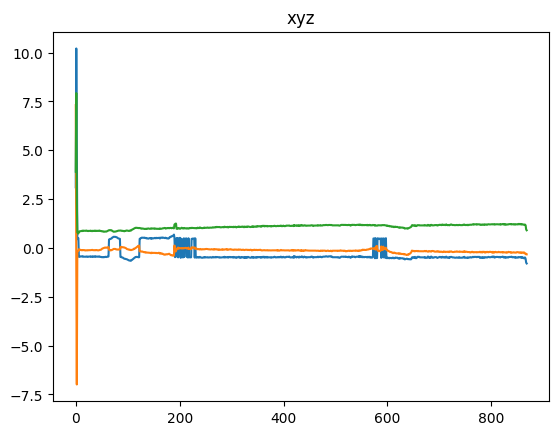

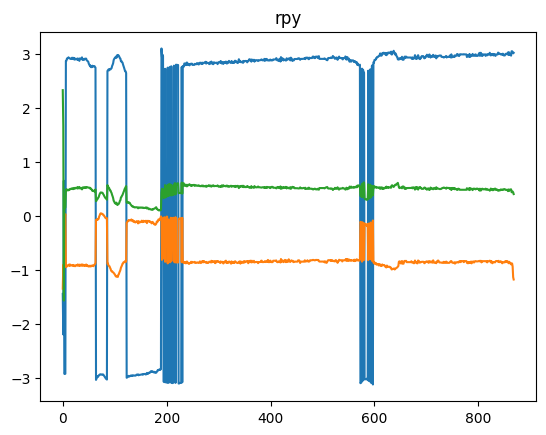

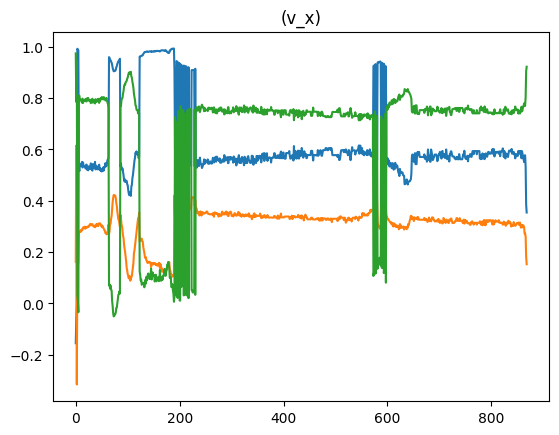

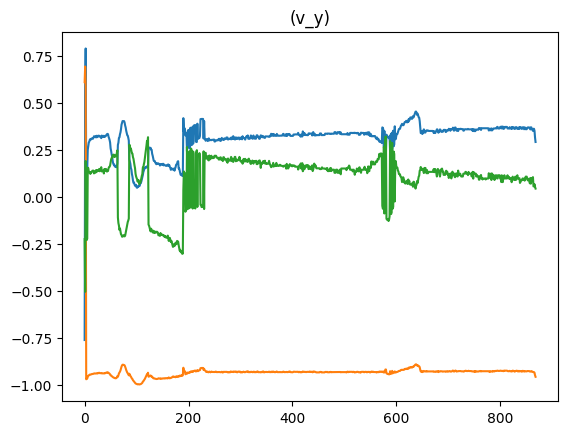

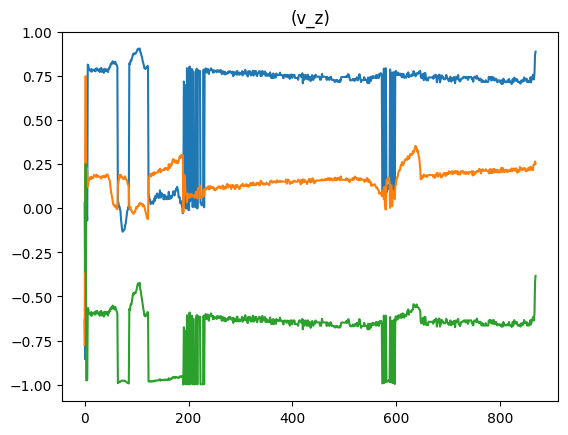

In [6]:
plt.title("xyz"); plt.plot(XYZ); plt.show()  # 青:x, 橙:y, 緑:z
plt.title("rpy"); plt.plot(RPY); plt.show()  # 青:r, 橙:p, 緑:y
plt.title("(v_x)"); plt.plot(V_x); plt.show()
plt.title("(v_y)"); plt.plot(V_y); plt.show()
plt.title("(v_z)"); plt.plot(V_z); plt.show()